In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

In [2]:
def curl_curl(n, r=1):    
    mesh = UnitSquareMesh(n, n)
    
    # start by solving for u using non-hybrid method
    S_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    V_element = FiniteElement('N2curl', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_element)
    
    bcs = [DirichletBC(W.sub(0), Constant(0), DomainBoundary()),
           DirichletBC(W.sub(1), Constant((0,0)), DomainBoundary())]

    s, u = TrialFunctions(W)
    t, v = TestFunctions(W) 
    a = (-inner(s, t) + inner(u, grad(t)) + inner(grad(s), v) + inner(curl(u), curl(v)))*dx
    #for q = curl u to match other formulations
    f = Expression(('-pow(pi,2)*sin(pi*x[1])','pow(pi,2)*sin(pi*x[0])'), degree=r+1)
    L = inner(f, v)*dx
    
    w = Function(W)
    solve(a == L, w, bcs)
    u = w.sub(1)

    curl_u = project(curl(u), FunctionSpace(mesh, "DG", r-1))
    
    # post-process
    V_dg_element = VectorElement('DG', mesh.ufl_cell(), r)
    Q_element = FiniteElement('CG', mesh.ufl_cell(), r+2)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(curl(q), curl(p)) + curl(lam*p + v*q) + 1e-10*inner(lam, v))*dx
    L = (inner(f, v + curl(p)) + inner(curl_u, p + curl(v)))*dx
    
    w = Function(W)
    solve(a == L, w)

    return u, w.sub(1)

def grad_div_rt(n, r=1):
    mesh = UnitSquareMesh(n, n)
    
    # start by solving for u using non-hybrid method
    S_element = FiniteElement('CG', mesh.ufl_cell(), r)
    V_element = FiniteElement('RT', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_element)
    bcs = [DirichletBC(W.sub(0), Constant(0), DomainBoundary()),
           DirichletBC(W.sub(1), Constant((0,0)), DomainBoundary())]

    s, u = TrialFunctions(W)
    t, v = TestFunctions(W)
    a = (-inner(s, t) + inner(u, curl(t)) + inner(curl(s), v) + inner(div(u), div(v)))*dx
    f = Expression(("pow(pi,2)*sin(pi*x[0])","pow(pi,2)*sin(pi*x[1])"), degree=r+1)
    L = inner(f, v)*dx
    
    w = Function(W)
    solve(a == L, w, bcs)
    u = w.sub(1)

    div_u = project(div(u), FunctionSpace(mesh, "DG", r-1))
    
    # post-process to estimate q = div(u) in H^1 instead of L^2
    V_dg_element = FiniteElement('DRT', mesh.ufl_cell(), r)
    Q_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(grad(q), grad(p)) - div(lam*p + v*q) + 1e-10*inner(lam, v))*dx
    L = (inner(f, v - grad(p)) + inner(div_u, p - div(v)))*dx
    
    w = Function(W)
    solve(a == L, w)

    return u, w.sub(1)

def grad_div_bdm(n, r=1):
    mesh = UnitSquareMesh(n, n)
    
    # start by solving for u using non-hybrid method
    S_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    V_element = FiniteElement('BDM', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_element)
    bcs = [DirichletBC(W.sub(0), Constant(0), DomainBoundary()),
           DirichletBC(W.sub(1), Constant((0,0)), DomainBoundary())]

    s, u = TrialFunctions(W)
    t, v = TestFunctions(W)
    a = (-inner(s, t) + inner(u, curl(t)) + inner(curl(s), v) + inner(div(u), div(v)))*dx
    f = Expression(("pow(pi,2)*sin(pi*x[0])","pow(pi,2)*sin(pi*x[1])"), degree=r+1)
    L = inner(f, v)*dx
    
    w = Function(W)
    solve(a == L, w, bcs)
    u = w.sub(1)

    div_u = project(div(u), FunctionSpace(mesh, "DG", r-1))
    
    # post-process to estimate q = div(u) in H^1 instead of L^2
    V_dg_element = VectorElement('DG', mesh.ufl_cell(), r)
    Q_element = FiniteElement('CG', mesh.ufl_cell(), r+2)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(grad(q), grad(p)) - div(lam*p + v*q) + 1e-10*inner(lam, v))*dx
    L = (inner(f, v - grad(p)) + inner(div_u, p - div(v)))*dx
    
    w = Function(W)
    solve(a == L, w)

    return u, w.sub(1)


1
2
3


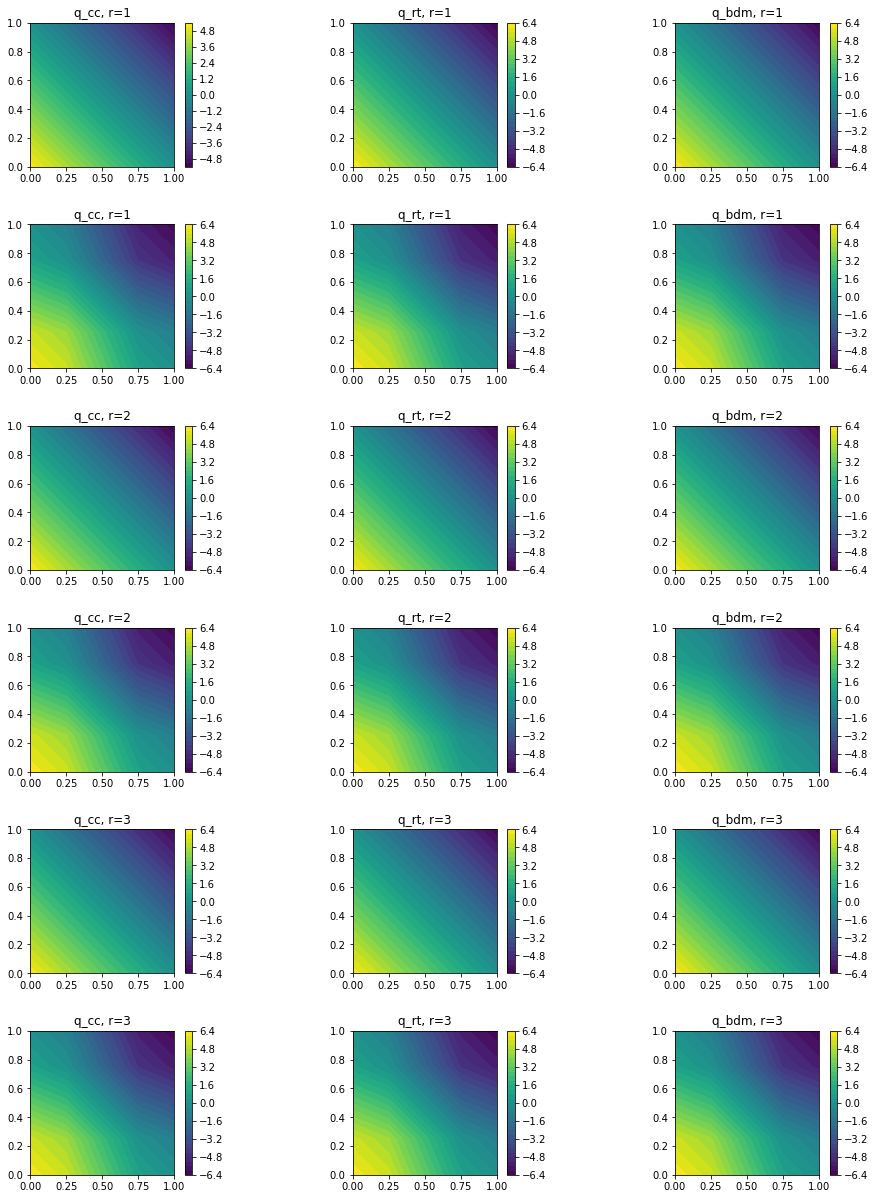

In [17]:
degrees = range(1,4)
ns = [2**k for k in range(1,3)]

num_ns = len(ns)
num_dgs = len(degrees)

u_es = []
q_es = []

errors = {}

for degree in degrees:
    print(degree)
    es = []
    for i, n in enumerate(ns):
        u_cc,  q_cc  = curl_curl(n, r=degree)
        u_rt,  q_rt  = grad_div_rt(n, r=degree)
        u_bdm, q_bdm = grad_div_bdm(n, r=degree)

        u_es.append([errornorm(u_cc, u_rt), errornorm(u_cc, u_bdm)])
        q_es.append([errornorm(q_cc, q_rt), errornorm(q_cc, q_bdm)])

        u_exact_cc = Expression(("-sin(pi*x[1])","sin(pi*x[0])"), degree=degree+3)
        u_exact = Expression(("sin(pi*x[0])","sin(pi*x[1])"), degree=degree+3)
        q_exact = Expression("pi*(cos(pi*x[0]) + cos(pi*x[1]))", degree=degree+4)

        es.append([errornorm(q_exact, q_cc),
                   errornorm(q_exact, q_rt),
                   errornorm(q_exact, q_bdm),
                   errornorm(u_exact_cc ,u_cc),
                   errornorm(u_exact, u_rt),
                   errornorm(u_exact, u_bdm)])

        # see that q_cc is rotated 90 version of q_rt & q_bdm
        plt.subplot(num_dgs*num_ns, 3, 3*(i+num_ns*(degree-1))+1)
        plt.title("q_cc, r=%d"%degree)
        a = plot(q_cc)
        plt.colorbar(a)
        plt.subplot(num_dgs*num_ns, 3, 3*(i+num_ns*(degree-1))+2)
        plt.title("q_rt, r=%d"%degree)
        b = plot(q_rt)
        plt.colorbar(b)
        plt.subplot(num_dgs*num_ns, 3, 3*(i+num_ns*(degree-1))+3)
        plt.title("q_bdm, r=%d"%degree)
        c = plot(q_bdm)
        plt.colorbar(c)

    errors[degree] = es
plt.subplots_adjust(wspace=0.5, hspace=.4, left=0.01, right=2.0, bottom=0, top=4)

In [18]:
q_es

[[0.21044306370264418, 0.2484698968686528],
 [0.013996340552215911, 0.01995610719174957],
 [0.011012266706255542, 0.012958299869001594],
 [0.0008171542483082525, 0.00094930506001981],
 [0.0008098337667955164, 0.0010241290168013883],
 [3.035457269276965e-05, 3.782675699877313e-05]]

In [19]:
u_es

[[1.2159334852579278, 1.1463930838635705],
 [1.3643566987046107, 1.346376874701109],
 [1.4092834203286084, 1.4086880748988682],
 [1.4138965934187282, 1.4138475701679984],
 [1.4141431801752815, 1.4141227096435012],
 [1.4142121605303992, 1.4142118277310638]]

[[0.24396323377418555, 0.07261220749620134, 0.02857270383760992, 0.2182534749936914, 0.46033869833862545, 0.2182534749936903], [0.01966469391973999, 0.008745124828918349, 0.001911347033753018, 0.053975760770743925, 0.22737622832875892, 0.0539757607707459]]
[[0.013954727908391173, 0.006326583433646736, 0.002440099162058256, 0.016208614420550216, 0.04406013921995689, 0.016208614420546136], [0.001030254494423732, 0.000411521845139079, 0.0001642539174077392, 0.002030905099797736, 0.011943250477809446, 0.002030905099789135]]
[[0.001059395559386816, 0.00048318212563268456, 0.00014831889399550708, 0.0017303918532840196, 0.007807752101737139, 0.001730391853284622], [3.8604847305503177e-05, 1.6260925795343304e-05, 2.528368798536239e-06, 0.00010442765206100225, 0.0009757365061753871, 0.00010442765206160275]]


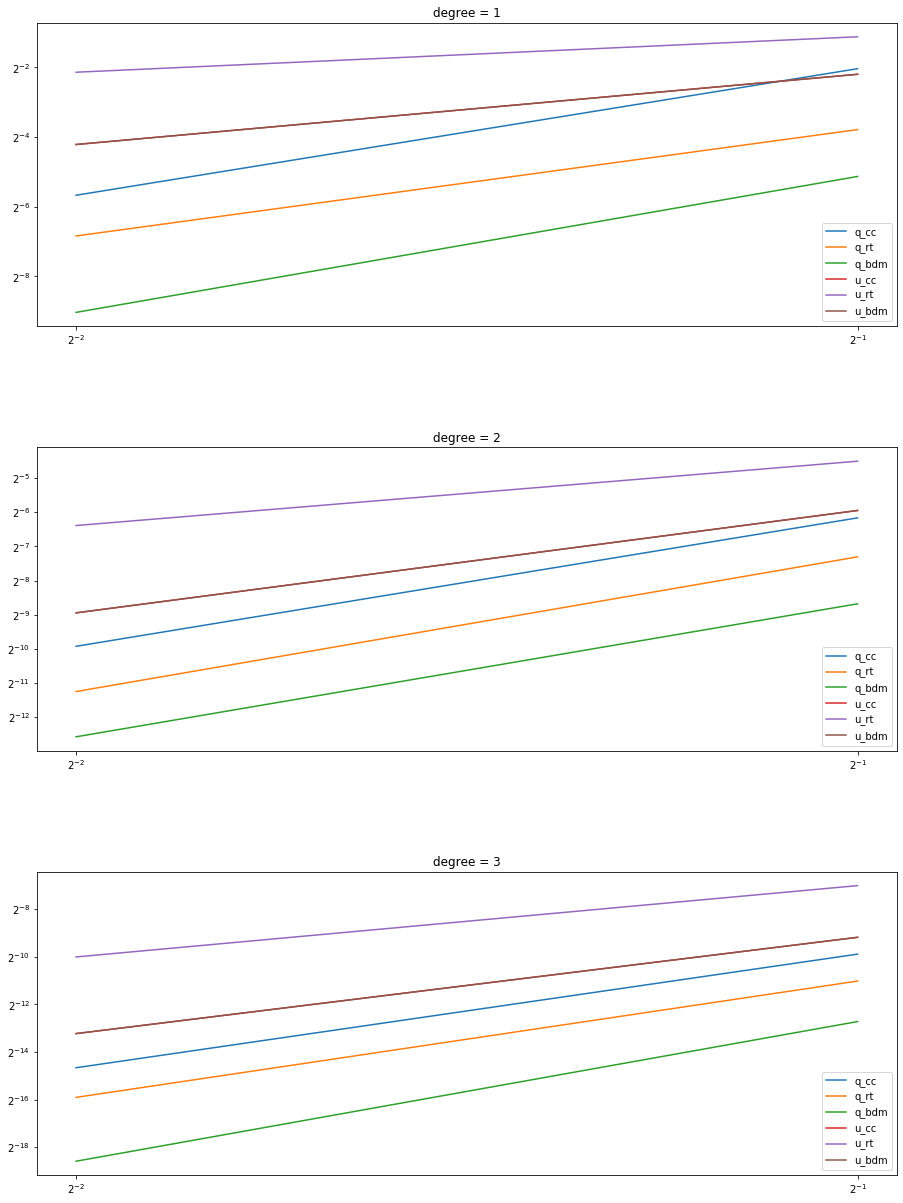

In [20]:

for degree in degrees:
    print(errors[degree])
    plt.subplot(num_dgs, 1, degree)
    plt.loglog(1/np.array(ns), errors[degree], basex=2, basey=2)
    plt.title("degree = %d"%degree)
    plt.legend(["q_cc", "q_rt", "q_bdm", "u_cc", "u_rt", "u_bdm"])

plt.subplots_adjust(wspace=0.5, hspace=.4, left=0.01, right=2.0, bottom=0, top=4)